# Hatchet Benchmark + Task Status

Simple notebook to benchmark Hatchet tasks and track run statuses over time.

## Before running
- Start the relevant worker(s) in another terminal.
- Ensure `HATCHET_CLIENT_TOKEN` is set.
- Configure `TASK_INPUTS` in the next cell.


In [1]:
import asyncio
import os
from dataclasses import is_dataclass
from datetime import datetime, timezone
from typing import Any

import pandas as pd
from dotenv import load_dotenv
from hatchet_sdk import EmptyModel, Hatchet
from hatchet_sdk.clients.rest.models.v1_task_status import V1TaskStatus
from pydantic import BaseModel

from hatchet_playground.task_schemas import resolve_task_schema

load_dotenv()
assert os.getenv("HATCHET_CLIENT_TOKEN"), "HATCHET_CLIENT_TOKEN is required"

hatchet = Hatchet()

# Map task name -> base input payload.
# For tasks with no input, use {}.
TASK_INPUTS: dict[str, dict[str, Any]] = {
    "externally-triggered-task": {"user_id": 1000},
    "sync-sleep-task": {},
}

RUNS_PER_TASK = 20
TRIGGER_CONCURRENCY = 10
POLL_INTERVAL_SECONDS = 1.0

TERMINAL_STATUSES = {
    V1TaskStatus.COMPLETED,
    V1TaskStatus.FAILED,
    V1TaskStatus.CANCELLED,
}


In [2]:
def create_stub(task_name: str):
    schema = resolve_task_schema(task_name)
    kwargs = {
        "name": task_name,
        "input_validator": schema.input_validator,
    }
    if schema.output_validator is not None:
        kwargs["output_validator"] = schema.output_validator
    return hatchet.stubs.task(**kwargs)


def build_input(task_name: str, payload: dict[str, Any]) -> Any:
    validator = resolve_task_schema(task_name).input_validator

    if validator is EmptyModel:
        return EmptyModel()

    if isinstance(validator, type) and issubclass(validator, BaseModel):
        return validator.model_validate(payload)

    if is_dataclass(validator):
        return validator(**payload)

    raise TypeError(f"Unsupported input validator for task={task_name}")


def payload_for(task_name: str, run_index: int) -> dict[str, Any]:
    payload = dict(TASK_INPUTS.get(task_name, {}))
    if isinstance(payload.get("user_id"), int):
        payload["user_id"] = payload["user_id"] + run_index
    return payload


async def trigger_task_runs(task_name: str, runs_per_task: int) -> pd.DataFrame:
    stub = create_stub(task_name)
    semaphore = asyncio.Semaphore(TRIGGER_CONCURRENCY)

    async def trigger_one(index: int) -> dict[str, Any]:
        async with semaphore:
            payload = build_input(task_name, payload_for(task_name, index))
            run_ref = await stub.aio_run_no_wait(input=payload)
            return {
                "task_name": task_name,
                "run_index": index,
                "workflow_run_id": run_ref.workflow_run_id,
                "triggered_at": datetime.now(timezone.utc),
            }

    rows = await asyncio.gather(*(trigger_one(i) for i in range(runs_per_task)))
    return pd.DataFrame(rows)


async def poll_statuses(run_df: pd.DataFrame) -> pd.DataFrame:
    run_ids = run_df["workflow_run_id"].tolist()
    run_to_task = dict(zip(run_df["workflow_run_id"], run_df["task_name"], strict=True))

    snapshots: list[dict[str, Any]] = []
    terminal_runs: set[str] = set()

    while len(terminal_runs) < len(run_ids):
        now = datetime.now(timezone.utc)
        statuses = await asyncio.gather(
            *(hatchet.runs.aio_get_status(run_id) for run_id in run_ids)
        )

        for run_id, status in zip(run_ids, statuses, strict=True):
            snapshots.append(
                {
                    "timestamp": now,
                    "workflow_run_id": run_id,
                    "task_name": run_to_task[run_id],
                    "status": status.value,
                }
            )
            if status in TERMINAL_STATUSES:
                terminal_runs.add(run_id)

        print(
            f"[{now.isoformat(timespec='seconds')}] terminal={len(terminal_runs)}/{len(run_ids)}"
        )

        if len(terminal_runs) < len(run_ids):
            await asyncio.sleep(POLL_INTERVAL_SECONDS)

    return pd.DataFrame(snapshots)


In [ ]:
async def run_benchmark() -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    tasks = list(TASK_INPUTS)
    if not tasks:
        raise ValueError("TASK_INPUTS is empty. Add at least one task to run.")

    triggered_parts = [
        await trigger_task_runs(task_name, RUNS_PER_TASK) for task_name in tasks
    ]
    triggered_df = pd.concat(triggered_parts, ignore_index=True)

    snapshots_df = await poll_statuses(triggered_df)

    latest_df = (
        snapshots_df.sort_values("timestamp")
        .groupby("workflow_run_id", as_index=False)
        .tail(1)
        .rename(columns={"timestamp": "last_seen_at", "status": "final_status"})
    )[["workflow_run_id", "last_seen_at", "final_status"]]

    merged_df = triggered_df.merge(latest_df, on="workflow_run_id", how="left")
    merged_df["duration_seconds"] = (
        merged_df["last_seen_at"] - merged_df["triggered_at"]
    ).dt.total_seconds()

    return triggered_df, snapshots_df, merged_df


triggered_df, snapshots_df, merged_df = await run_benchmark()

print("Final status counts:")
display(
    merged_df.groupby(["task_name", "final_status"], as_index=False)
    .size()
    .rename(columns={"size": "count"})
)

print("Duration summary (seconds):")
display(merged_df.groupby("task_name", as_index=False)["duration_seconds"].describe())


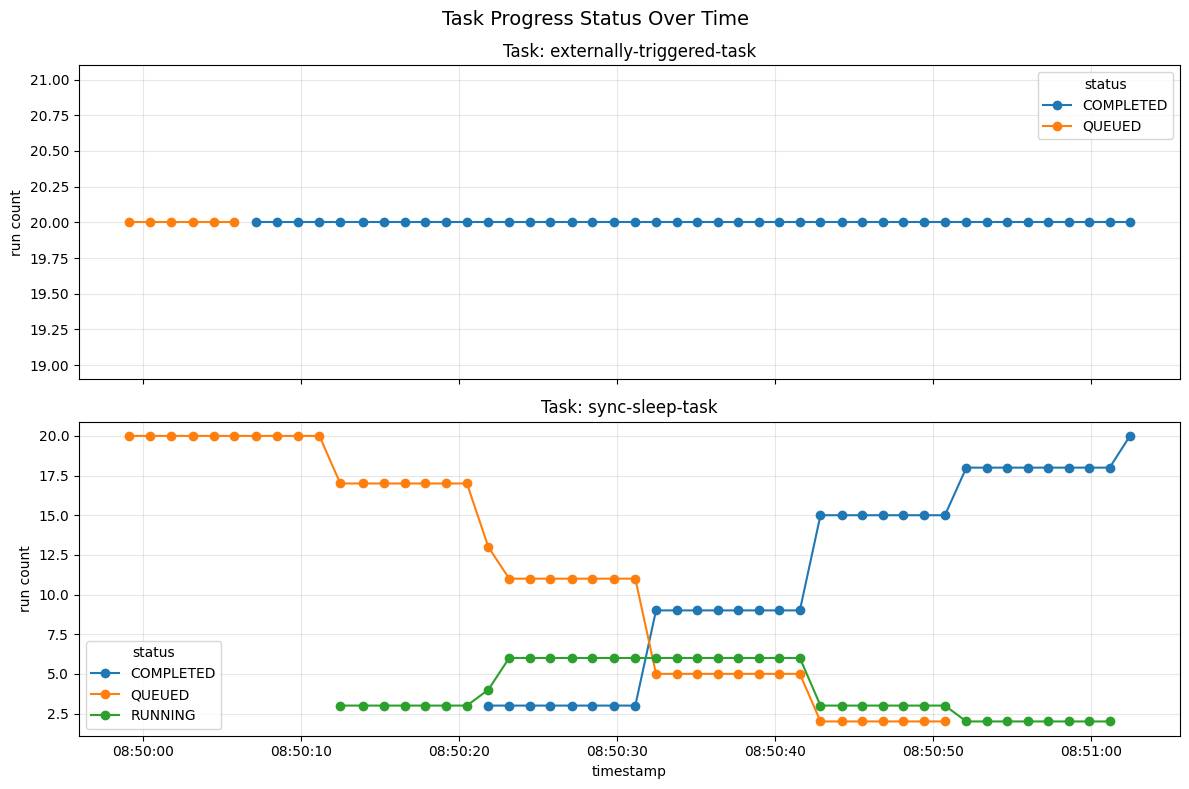

Latest status snapshot:


,timestamp,task_name,status,count
139,2026-02-15 08:50:54.696924+00:00,externally-triggered-task,COMPLETED,20
140,2026-02-15 08:50:54.696924+00:00,sync-sleep-task,COMPLETED,18
141,2026-02-15 08:50:54.696924+00:00,sync-sleep-task,RUNNING,2
142,2026-02-15 08:50:55.978975+00:00,externally-triggered-task,COMPLETED,20
143,2026-02-15 08:50:55.978975+00:00,sync-sleep-task,COMPLETED,18
144,2026-02-15 08:50:55.978975+00:00,sync-sleep-task,RUNNING,2
145,2026-02-15 08:50:57.295342+00:00,externally-triggered-task,COMPLETED,20
146,2026-02-15 08:50:57.295342+00:00,sync-sleep-task,COMPLETED,18
147,2026-02-15 08:50:57.295342+00:00,sync-sleep-task,RUNNING,2
148,2026-02-15 08:50:58.584945+00:00,externally-triggered-task,COMPLETED,20


In [ ]:
import matplotlib.pyplot as plt

status_counts_df = (
    snapshots_df.groupby(["timestamp", "task_name", "status"], as_index=False)
    .size()
    .rename(columns={"size": "count"})
)

task_names = sorted(status_counts_df["task_name"].unique())
fig, axes = plt.subplots(
    len(task_names), 1, figsize=(12, 4 * max(1, len(task_names))), sharex=True
)
if len(task_names) == 1:
    axes = [axes]

for ax, task_name in zip(axes, task_names, strict=True):
    task_df = status_counts_df[status_counts_df["task_name"] == task_name]
    for status in sorted(task_df["status"].unique()):
        line_df = task_df[task_df["status"] == status].sort_values("timestamp")
        ax.plot(line_df["timestamp"], line_df["count"], marker="o", label=status)
    ax.set_title(f"Task: {task_name}")
    ax.set_ylabel("run count")
    ax.grid(alpha=0.3)
    ax.legend(title="status")

axes[-1].set_xlabel("timestamp")
fig.suptitle("Task Progress Status Over Time", fontsize=14)
plt.tight_layout()
plt.show()

print("Latest status snapshot:")
display(status_counts_df.sort_values(["timestamp", "task_name", "status"]).tail(20))
